In [1]:
import sys

sys.path.append(".")

import matplotlib.pyplot as plt

import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from src.components.components import *
from src.models.unet import UNet
from src.modules.rectified_flow import RectifiedFlowModule

import pytorch_lightning as pl

import sys

sys.path.append(".")

/home/engineer/anaconda/envs/palamariuk-genai/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_dataset = torchvision.datasets.MNIST(root="./data", train=True, transform=transform, download=True)
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Device: {device}\n')

Device: cuda



# 4

(10pt.) Implement and train diffusion model (pixel and latent based) using Rectified Flow

In [4]:
model_flow = UNet(
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_mults=(1, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=[1]
).to(device)

flow_module = RectifiedFlowModule(model=model_flow, lr=1e-3, mode="flow").to(device)

In [40]:
model_flow

UNet(
  (time_embedding): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=128, out_features=512, bias=True)
    (2): SiLU()
    (3): Linear(in_features=512, out_features=128, bias=True)
  )
  (initial_conv): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (down_blocks): ModuleList(
    (0): DownBlock(
      (res_blocks): ModuleList(
        (0-1): 2 x ResBlock(
          (time_mlp): Sequential(
            (0): SiLU()
            (1): Linear(in_features=128, out_features=64, bias=True)
          )
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
          (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
          (residual_conv): Identity()
        )
      )
      (downsample): Downsample(
        (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 

In [23]:
retrain = True

if retrain:
    trainer = pl.Trainer(max_epochs=40, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(flow_module, train_loader)
    torch.save(flow_module.model, 'models/weights/flow_model.pth')
else:
    flow_module.model = torch.load('models/weights/flow_model.pth', weights_only=False).to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 3.4 M  | eval 
1 | criterion | MSELoss | 0      | train
----------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.780    Total estimated model params size (MB)
1         Modules in train mode
136       Modules in eval mode


Epoch 39: 100%|██████████| 235/235 [00:18<00:00, 12.50it/s, v_num=23]

`Trainer.fit` stopped: `max_epochs=40` reached.


Epoch 39: 100%|██████████| 235/235 [00:19<00:00, 12.28it/s, v_num=23]


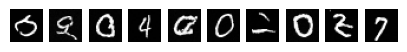

In [49]:
noise_samples = torch.randn(16, 1, 28, 28, device=device)
samples = flow_module.sample(noise_samples, num_steps=100).cpu()

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()

In [29]:
fixed_dataset = flow_module.generate_fixed_pairs(num_fixed=10000, batch_size=256, num_steps=200)
fixed_loader = DataLoader(fixed_dataset, batch_size=256, shuffle=True)
torch.save(fixed_dataset, "fixed_pairs_dataset.pt")

In [30]:
model_reflow = UNet(
    in_channels=1,
    out_channels=1,
    base_channels=64,
    channel_mults=(1, 2),
    num_res_blocks=2,
    time_emb_dim=128,
    attn_resolutions=[1]
).to(device)

reflow_module = RectifiedFlowModule(model=model_reflow, lr=1e-3, mode="reflow").to(device)

In [34]:
reflow_module = reflow_module.to(device)

In [32]:
retrain = True

if retrain:
    trainer = pl.Trainer(max_epochs=90, accelerator="gpu" if torch.cuda.is_available() else "cpu")
    trainer.fit(reflow_module, fixed_loader)
    torch.save(reflow_module.model, 'models/weights/reflow_model.pth')
else:
    reflow_module.model = torch.load('models/weights/reflow_model.pth', weights_only=False).to(device)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [1]

  | Name      | Type    | Params | Mode 
----------------------------------------------
0 | model     | UNet    | 3.4 M  | train
1 | criterion | MSELoss | 0      | train
----------------------------------------------
3.4 M     Trainable params
0         Non-trainable params
3.4 M     Total params
13.780    Total estimated model params size (MB)
137       Modules in train mode
0         Modules in eval mode


Epoch 89: 100%|██████████| 39/39 [00:04<00:00,  9.17it/s, v_num=25]

`Trainer.fit` stopped: `max_epochs=90` reached.


Epoch 89: 100%|██████████| 39/39 [00:04<00:00,  8.34it/s, v_num=25]


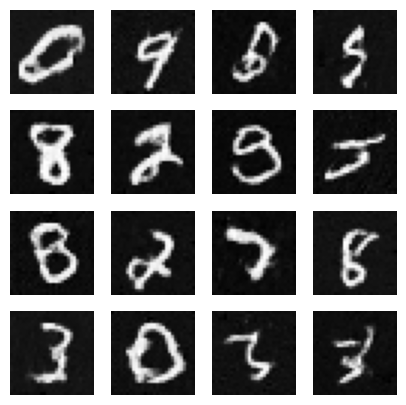

In [35]:
noise_samples = torch.randn(16, 1, 28, 28, device=device)
samples = reflow_module.sample(noise_samples, num_steps=1).cpu()

fig, axes = plt.subplots(4, 4, figsize=(5, 5))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()

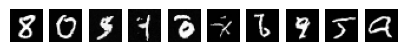

In [59]:
noise_samples = torch.randn(10, 1, 28, 28, device=device)
samples = reflow_module.sample(noise_samples, num_steps=100).cpu()

fig, axes = plt.subplots(1, 10, figsize=(5, 50))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(samples[i, 0], cmap="gray")
    ax.axis("off")
plt.show()